# Procesamiento de datos

En este archivo se presenta el procesamiento de los datos para la clasificación de emociones. Previamente se debe descargar el siguiente Dataset: [Dataset de Speech Emotions](https://www.kaggle.com/datasets/uldisvalainis/audio-emotions/download?datasetVersionNumber=1 ), que contiene 12.782 audios distribuidos en 7 categorias que son: Angry (0) Disgusted(1), Fearful(2), Happy(3), Neutral(4), Sad(5) y Surprised(6). 


In [30]:
import os

import librosa
from librosa import display
import scipy
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import IPython
import IPython.display as ipd
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from IPython.display import Audio
import time

### Variables de entorno

In [26]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/'ML Proyecto'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ML Proyecto


In [27]:
# Poner aqui la ruta del dataset de speech emotions previamente cargado
DATASET = './Dataset/Emotions' 


Funciones de procesamiento

In [25]:
def remove_silence(signal, threshold=0.005):
    """
    Remove silence at the beginning and at the end of the signal
    """
    for i in range(len(signal)):
        if np.abs(signal[i]) > threshold:
            break
    for j in range(len(signal)-1, 0, -1):
        if np.abs(signal[j]) > threshold:
            break
    return signal[i:j]

Leer un Audio

In [31]:
def ensure_sample_rate(waveform, original_sample_rate, desired_sample_rate=16000):
    if original_sample_rate != desired_sample_rate:
        desired_length = int(round(float(len(waveform)) / original_sample_rate * desired_sample_rate))
        waveform = scipy.signal.resample(waveform, desired_length)
    return waveform, desired_sample_rate

wav_path = f'{DATASET}/Angry/03-01-05-01-01-01-01.wav'
wav_data, sample_rate = librosa.load(wav_path)
print(f'Original sample rate: {sample_rate} Hz')

# Asegurarse que la muestra este en el rango de 16 kHz y calcular la longitud de las muestras
waveform, sample_rate = ensure_sample_rate(wav_data, sample_rate)
duration = len(waveform)/sample_rate

# Mostrar información básica que contiene el audio
print(f'Model Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(waveform)}')

# Escuchar el audio 
Audio(waveform, rate=sample_rate)

Original sample rate: 22050 Hz
Model Sample rate: 16000 Hz
Total duration: 3.87s
Size of the input: 61929


Procesamiento del Audio

In [32]:
lst = [] # Obtención de los datos: vector caracteristicas y categorias
i = 0
start_time = time.time()
for subdir, dirs, files in os.walk(DATASET):
  print(subdir)
  print(i)
  for file in files:
    X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
    X = remove_silence(X)
    if len(X) == 0:
      continue

    mfcc_values = librosa.feature.mfcc(y=X, sr=sample_rate, n_fft=4096, hop_length=256, n_mfcc=128).T 
    mfccs_mean = np.mean(mfcc_values, axis=0) # media en los coeficientes
    mfccs_std = np.std(mfcc_values, axis=0) # Desviación estandar en los coeficientes
    mfccs = np.concatenate((mfccs_mean, mfccs_std), axis=0)
    lst.append((mfccs, i))

  if files:
    i = i + 1
    print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

./Dataset/Emotions
0
./Dataset/Emotions/Angry
0
--- Data loaded. Loading time: 194.60113787651062 seconds ---
./Dataset/Emotions/Disgusted
1
--- Data loaded. Loading time: 322.92431020736694 seconds ---
./Dataset/Emotions/Fearful
2
--- Data loaded. Loading time: 493.23793959617615 seconds ---
./Dataset/Emotions/Happy
3
--- Data loaded. Loading time: 691.2164418697357 seconds ---
./Dataset/Emotions/Neutral
4
--- Data loaded. Loading time: 813.4148826599121 seconds ---
./Dataset/Emotions/Sad
5
--- Data loaded. Loading time: 1017.4373738765717 seconds ---
./Dataset/Emotions/Suprised
6
--- Data loaded. Loading time: 1071.8227365016937 seconds ---


In [33]:
# Ditribución de las Labels
labels = {
    'Angry': 0,
    'Disgusted': 1,
    'Fearful': 2,
    'Happy': 3,
    'Neutral': 4,
    'Sad': 5,
    'Suprised': 6
}

## Grafica de las formas de Onda del Audio 

In [34]:
#Adicionar las rutas

file1='/content/drive/MyDrive/ML Proyecto/Dataset/Emotions/Neutral/03-02-01-01-02-02-20.wav'
signal1, sample_rate = librosa.load(file1, sr=22050)

file2='/content/drive/MyDrive/ML Proyecto/Dataset/Emotions/Neutral/1007_WSI_NEU_XX.wav'
signal2, sample_rate = librosa.load(file2, sr=22050)

file3='/content/drive/MyDrive/ML Proyecto/Dataset/Emotions/Neutral/n01.wav'
signal3, sample_rate = librosa.load(file3, sr=22050)

file4='/content/drive/MyDrive/ML Proyecto/Dataset/Emotions/Neutral/YAF_vote_neutral.wav'
signal4, sample_rate = librosa.load(file4, sr=22050)

emotion='Neutral'

Text(0.5, 1.0, 'TESS Waveform Neutral')

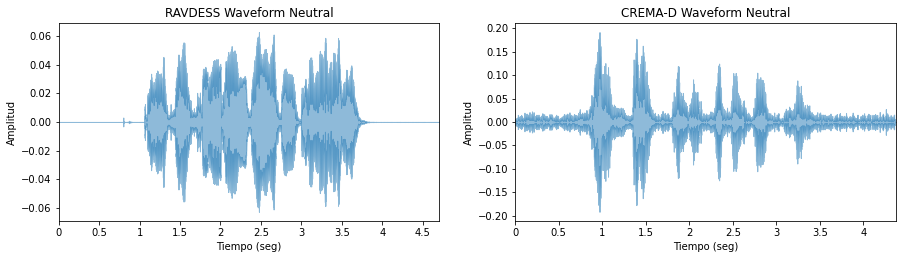

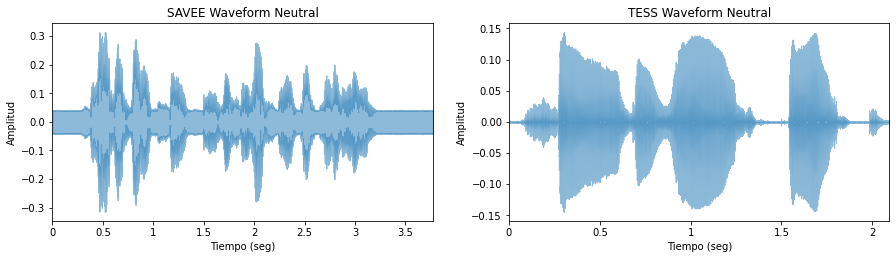

In [35]:
from librosa import display
fig = plt.figure(figsize=(15,8))
# Forma de Onda
# Muestra las formas de Onda para el sentimiento Neutral
plt.subplot(2, 2, 1)
librosa.display.waveplot(signal1,sample_rate, alpha=0.5)
plt.xlabel("Tiempo (seg)")
plt.ylabel("Amplitud")
plt.title("RAVDESS Waveform "+emotion)

plt.subplot(2, 2, 2)
librosa.display.waveplot(signal2,sample_rate, alpha=0.5)
plt.xlabel("Tiempo (seg)")
plt.ylabel("Amplitud")
plt.title("CREMA-D Waveform "+emotion)


fig = plt.figure(figsize=(15,8))
plt.subplot(2, 2, 3)
librosa.display.waveplot(signal3,sample_rate, alpha=0.5)
plt.xlabel("Tiempo (seg)")
plt.ylabel("Amplitud")
plt.title("SAVEE Waveform "+emotion)

plt.subplot(2, 2, 4)
librosa.display.waveplot(signal4,sample_rate, alpha=0.5)
plt.xlabel("Tiempo (seg)")
plt.ylabel("Amplitud")
plt.title("TESS Waveform "+emotion)

Espectros y Transformada de Fourier

Text(0.5, 1.0, 'TESS Power Espectro Neutral')

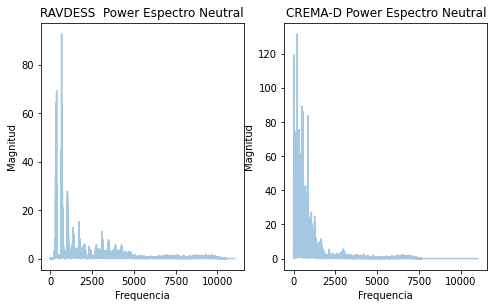

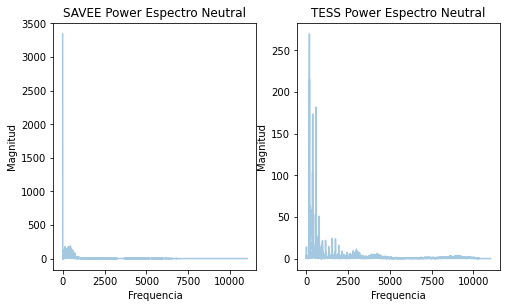

In [36]:
# Transformada de Fourier para la señal
fft1 = np.fft.fft(signal1)
fft2 = np.fft.fft(signal2)
fft3 = np.fft.fft(signal3)
fft4 = np.fft.fft(signal4)

# calculo de los valores absolutos en numeros complejos para obtener la magnitud
spectrum1 = np.abs(fft1)
spectrum2 = np.abs(fft2)
spectrum3 = np.abs(fft3)
spectrum4 = np.abs(fft4)

# Crear la frecuencia variable
f1 = np.linspace(0, sample_rate, len(spectrum1)) 
f2 = np.linspace(0, sample_rate, len(spectrum2))
f3 = np.linspace(0, sample_rate, len(spectrum3))
f4 = np.linspace(0, sample_rate, len(spectrum4))

# Tomar la mitad del espectro y la frecuencia
left_spectrum1 = spectrum1[:int(len(spectrum1)/2)]
left_f1 = f1[:int(len(spectrum1)/2)]
# tomar la mitad del espectro y la frecuencia
left_spectrum2 = spectrum2[:int(len(spectrum2)/2)]
left_f2 = f2[:int(len(spectrum2)/2)]
# tomar la mitad del espectro y la frecuencia
left_spectrum3 = spectrum3[:int(len(spectrum3)/2)]
left_f3 = f3[:int(len(spectrum3)/2)]
# tomar la mitad del espectro y la frecuencia (Ahora los datos estan en el dominio de la frecuencia)
left_spectrum4 = spectrum4[:int(len(spectrum4)/2)]
left_f4 = f4[:int(len(spectrum4)/2)]

fig = plt.figure(figsize=(8,10))
plt.subplot(2, 2, 1)
# Gráfica del Espectro
plt.plot(left_f1, left_spectrum1, alpha=0.4)
plt.xlabel("Frequencia")
plt.ylabel("Magnitud")
plt.title("RAVDESS  Power Espectro "+emotion)

plt.subplot(2, 2,2)
# Grafica del espectro
plt.plot(left_f2, left_spectrum2, alpha=0.4)
plt.xlabel("Frequencia")
plt.ylabel("Magnitud")
plt.title("CREMA-D Power Espectro "+emotion)


fig = plt.figure(figsize=(8,10))

plt.subplot(2, 2, 3)
plt.plot(left_f3, left_spectrum3, alpha=0.4)
plt.xlabel("Frequencia")
plt.ylabel("Magnitud")
plt.title("SAVEE Power Espectro "+emotion)

plt.subplot(2, 2, 4)
plt.plot(left_f4, left_spectrum4, alpha=0.4)
plt.xlabel("Frequencia")
plt.ylabel("Magnitud")
plt.title("TESS Power Espectro "+emotion)

Espectrogramas

La duración del hop length STFT es: 0.011609977324263039s
La duración de la ventana STFT es: 0.18575963718820862s


Text(0.5, 1.0, 'TESS Espectrograma Neutral')

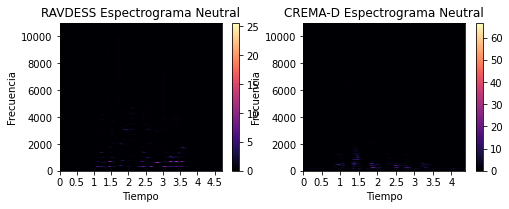

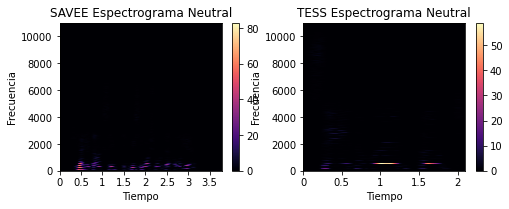

In [37]:
# STFT -> Espectrograma
#La longitud de salto (hop length) es la longitud de la parte que no se cruza de la longitud de la ventana.
hop_length =256 # número de muestras de audio entre columnas STFT adyacentes.
n_fft = 4096 # ventana en numero de muestras de audio

# calculo de la duración del hop length y la ventan en segundos
hop_length_duration = float(hop_length)/sample_rate
n_fft_duration = float(n_fft)/sample_rate

print("La duración del hop length STFT es: {}s".format(hop_length_duration))
print("La duración de la ventana STFT es: {}s".format(n_fft_duration))

# se realiza el stft (Transformada de Fourier de Tiempo Corto)
stft1 = librosa.stft(signal1, n_fft=n_fft, hop_length=hop_length) # devuelve una matriz de numeros complejos
stft2 = librosa.stft(signal2, n_fft=n_fft, hop_length=hop_length)
stft3 = librosa.stft(signal3, n_fft=n_fft, hop_length=hop_length)
stft4 = librosa.stft(signal4, n_fft=n_fft, hop_length=hop_length)

# calcula los valores absolutos en numeros complejos para obtener su magnitud
spectrogram1 = np.abs(stft1)
spectrogram2 = np.abs(stft2)
spectrogram3 = np.abs(stft3)
spectrogram4 = np.abs(stft4)

# Muestra los espectrogramas
fig = plt.figure(figsize=(8,6))
plt.subplot(2, 2, 1)
librosa.display.specshow(spectrogram1, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='hz')
plt.xlabel("Tiempo")
plt.ylabel("Frecuencia")
plt.colorbar()
plt.title("RAVDESS Espectrograma "+emotion)

plt.subplot(2, 2,2)
librosa.display.specshow(spectrogram2, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='hz')
plt.xlabel("Tiempo")
plt.ylabel("Frecuencia")
plt.colorbar()
plt.title("CREMA-D Espectrograma "+emotion)


fig = plt.figure(figsize=(8,6))
plt.subplot(2, 2, 3)
librosa.display.specshow(spectrogram3, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='hz')
plt.xlabel("Tiempo")
plt.ylabel("Frecuencia")
plt.colorbar()
plt.title("SAVEE Espectrograma "+emotion)

plt.subplot(2, 2, 4)
librosa.display.specshow(spectrogram4, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='hz')
plt.xlabel("Tiempo")
plt.ylabel("Frecuencia")
plt.colorbar()
plt.title("TESS Espectrograma "+emotion)

Text(0.5, 1.0, 'TESS Espectrograma (dB) Neutral')

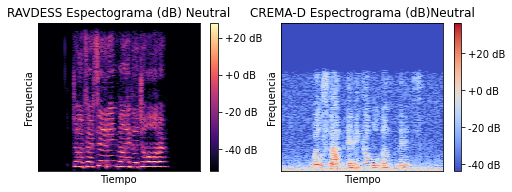

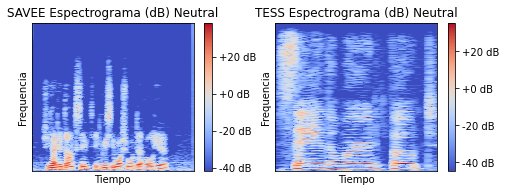

In [38]:
#Para visualizar mejor el espectrograma se opta aplicar el logaritmo para convertir la amplitud en decibelios
log_spectrogram1 = librosa.amplitude_to_db(spectrogram1)
log_spectrogram2 = librosa.amplitude_to_db(spectrogram2)
log_spectrogram3 = librosa.amplitude_to_db(spectrogram3)
log_spectrogram4 = librosa.amplitude_to_db(spectrogram4)

fig = plt.figure(figsize=(8,6))
plt.subplot(2, 2, 1)
librosa.display.specshow(log_spectrogram1, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Tiempo")
plt.ylabel("Frequencia")
plt.colorbar(format="%+2.0f dB")
plt.title("RAVDESS Espectograma (dB) "+emotion)

plt.subplot(2, 2,2)
librosa.display.specshow(log_spectrogram2, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Tiempo")
plt.ylabel("Frequencia")
plt.colorbar(format="%+2.0f dB")
plt.title("CREMA-D Espectrograma (dB)"+emotion)


fig = plt.figure(figsize=(8,6))
plt.subplot(2, 2, 3)
librosa.display.specshow(log_spectrogram3, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Tiempo")
plt.ylabel("Frequencia")
plt.colorbar(format="%+2.0f dB")
plt.title("SAVEE Espectrograma (dB) "+emotion)

plt.subplot(2, 2, 4)
librosa.display.specshow(log_spectrogram4, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Tiempo")
plt.ylabel("Frequencia")
plt.colorbar(format="%+2.0f dB")
plt.title("TESS Espectrograma (dB) "+emotion)

Text(0.5, 1.0, 'TESS MFCCs Neutral')

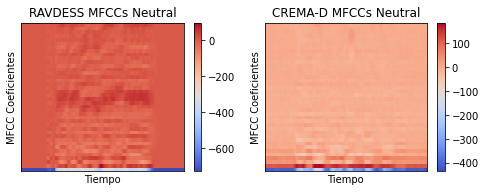

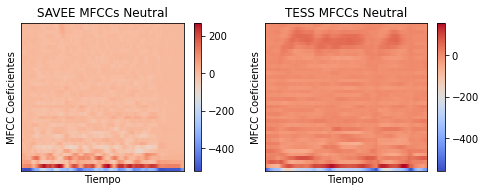

In [39]:
# MFCCs
# Extracción de los MFCC
MFCCs1 = librosa.feature.mfcc(signal1, sample_rate, n_fft=4096, hop_length=256, n_mfcc=40)
MFCCs2 = librosa.feature.mfcc(signal2, sample_rate, n_fft=4096, hop_length=256, n_mfcc=40)
MFCCs3 = librosa.feature.mfcc(signal3, sample_rate, n_fft=4096, hop_length=256, n_mfcc=40)
MFCCs4 = librosa.feature.mfcc(signal4, sample_rate, n_fft=4096, hop_length=256, n_mfcc=40)
# Mostrar los MFCC
hop_length=256 
fig = plt.figure(figsize=(8,6))
plt.subplot(2, 2, 1)
librosa.display.specshow(MFCCs1, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Tiempo")
plt.ylabel("MFCC Coeficientes")
plt.colorbar()
plt.title("RAVDESS MFCCs "+emotion)

plt.subplot(2, 2,2)
librosa.display.specshow(MFCCs2, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Tiempo")
plt.ylabel("MFCC Coeficientes")
plt.colorbar()
plt.title("CREMA-D MFCCs "+emotion)


fig = plt.figure(figsize=(8,6))
plt.subplot(2, 2, 3)
librosa.display.specshow(MFCCs3, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Tiempo")
plt.ylabel("MFCC Coeficientes")
plt.colorbar()
plt.title("SAVEE MFCCs "+emotion)


plt.subplot(2, 2, 4)
librosa.display.specshow(MFCCs4, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Tiempo")
plt.ylabel("MFCC Coeficientes")
plt.colorbar()
plt.title("TESS MFCCs "+emotion)                             

Los Coeficientes Cepstrales en la Escala de Mel(MFCC) representan la amplitud del espectro del habla de manera compacta, esto los ha vuelto la técnica de extracción de características más usada en reconocimiento del habla.[MFCC](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum#:~:text=Mel%2Dfrequency%20cepstral%20coefficients%20(MFCCs,%2Da%2Dspectrum%22)
